## Chapter 7. A peek into autoencoders

### 7.2. AUTOENCODERS

In [7]:
import tensorflow as tf
import numpy as np

In [10]:
np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]]) + np.array([2,3,4,5])

array([[3, 4, 5, 6],
       [4, 5, 6, 7],
       [5, 6, 7, 8],
       [6, 7, 8, 9]])

In [76]:
class Autoencoder:
    
    def __init__(self, input_dim, hidden_dim, epoch=250, learning_rate=0.001):  
        """
        The constructor will set up all the TensorFlow variables, placeholders, optimizers, and operators. 
        Anything that doesn’t immediately need a session can go in the constructor.
        """
        self.epoch = epoch               
        self.learning_rate = learning_rate

        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])      

        with tf.name_scope('encode'):                        
            weights = tf.Variable(tf.random_normal([input_dim, hidden_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([hidden_dim]), name='biases')
            encoded = tf.nn.tanh(tf.matmul(x, weights) + biases)
            
        with tf.name_scope('decode'):                     
            weights = tf.Variable(tf.random_normal([hidden_dim, input_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([input_dim]), name='biases')
            decoded = tf.matmul(encoded, weights) + biases

        self.x = x                                             
        self.encoded = encoded  
        self.decoded = decoded

        self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.decoded))))
        
        self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
        self.saver = tf.train.Saver()

    def train(self, data):                        
        num_samples = len(data)
        with tf.Session() as sess:                                
            sess.run(tf.global_variables_initializer())
            
            for i in range(self.epoch):                           
                for j in range(num_samples):
                    l, _ = sess.run([self.loss, self.train_op],feed_dict={self.x: data[j]})   
                    
                if i % 10 == 0:                                   
                    print('epoch {0}: loss = {1}'.format(i, l))   
                    self.saver.save(sess, './model.ckpt') 
                    
            self.saver.save(sess, './model.ckpt')               

    def test(self, data):     
        
        with tf.Session() as sess:
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x: data})
            
        print('input', data)
        print('compressed', hidden)
        print('reconstructed', reconstructed)
        print('reconstructed shape', reconstructed.shape)
        
        return reconstructed
    
    def classify(self, data, labels):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x: data})
            reconstructed = reconstructed[0]
            
            # loss = sess.run(self.all_loss, feed_dict={self.x: data})
            print('data', np.shape(data))
            print('reconstructed', np.shape(reconstructed))
            
            loss = np.sqrt(np.mean(np.square(data - reconstructed), axis=1))
            print('loss', np.shape(loss))
            
            horse_indices = np.where(labels == 7)[0]
            not_horse_indices = np.where(labels != 7)[0]
            horse_loss = np.mean(loss[horse_indices])
            not_horse_loss = np.mean(loss[not_horse_indices])
            
            print('horse', horse_loss)
            print('not horse', not_horse_loss)
            return hidden


In [32]:
from sklearn import datasets

hidden_dim = 1
data = datasets.load_iris().data

input_dim = len(data[0])

ae = Autoencoder(input_dim, hidden_dim)

ae.train(data)

ae.test([[8, 4, 6, 2]])

epoch 0: loss = 3.84677791595459
epoch 10: loss = 1.6354140043258667
epoch 20: loss = 0.7696962356567383
epoch 30: loss = 0.40451157093048096
epoch 40: loss = 0.3429800868034363
epoch 50: loss = 0.33716776967048645
epoch 60: loss = 0.3327878713607788
epoch 70: loss = 0.326534628868103
epoch 80: loss = 0.3179718255996704
epoch 90: loss = 0.3068365454673767
epoch 100: loss = 0.2929355502128601
epoch 110: loss = 0.2763429880142212
epoch 120: loss = 0.25743523240089417
epoch 130: loss = 0.23601295053958893
epoch 140: loss = 0.2228296399116516
epoch 150: loss = 0.21785002946853638
epoch 160: loss = 0.22063545882701874
epoch 170: loss = 0.23126961290836334
epoch 180: loss = 0.24841967225074768
epoch 190: loss = 0.2673497200012207
epoch 200: loss = 0.277983695268631
epoch 210: loss = 0.27683186531066895
epoch 220: loss = 0.271180123090744
epoch 230: loss = 0.2662600576877594
epoch 240: loss = 0.2630375325679779
INFO:tensorflow:Restoring parameters from ./model.ckpt
input [[8, 4, 6, 2]]
compre

array([[6.3771873, 2.8754098, 5.205508 , 1.8144557]], dtype=float32)

Running the train function will output debug info about how the loss decreases over the epochs. The test function shows info about the encoding and decoding process.

In [29]:
data[0].shape

(4,)

In [30]:
np.array([[8, 4, 6, 2]]).shape

(1, 4)

### 7.3. BATCH TRAINING

In [33]:
 def get_batch(X, size):
    a = np.random.choice(len(X), size, replace=False)
    return X[a]

In [44]:
class AutoencoderBatch(Autoencoder):
    def __init__(self, input_dim, hidden_dim, epoch=250, learning_rate=0.001):
        super().__init__(input_dim, hidden_dim, epoch, learning_rate)
        
    def train(self, data, batch_size=10):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for i in range(self.epoch):
                for j in range(500):                                  
                    batch_data = get_batch(data, batch_size)     
                    l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x: batch_data})
    
                if i % 10 == 0:
                    print('epoch {0}: loss = {1}'.format(i, l))
                    self.saver.save(sess, './model.ckpt')
                    
            self.saver.save(sess, './model.ckpt')

In [45]:
ae = AutoencoderBatch(input_dim, hidden_dim)

ae.train(data)

ae.test([[8, 4, 6, 2]])

epoch 0: loss = 2.6363024711608887
epoch 10: loss = 1.0925068855285645
epoch 20: loss = 0.9361787438392639
epoch 30: loss = 1.206675410270691
epoch 40: loss = 0.871934711933136
epoch 50: loss = 1.0045976638793945
epoch 60: loss = 1.1220272779464722
epoch 70: loss = 0.9350913763046265
epoch 80: loss = 0.845188319683075
epoch 90: loss = 0.9002195596694946
epoch 100: loss = 0.857448160648346
epoch 110: loss = 0.8786964416503906
epoch 120: loss = 0.9661978483200073
epoch 130: loss = 1.1443853378295898
epoch 140: loss = 0.9914859533309937
epoch 150: loss = 0.8054789900779724
epoch 160: loss = 0.9900503754615784
epoch 170: loss = 1.0313115119934082
epoch 180: loss = 1.0719255208969116
epoch 190: loss = 1.1349983215332031
epoch 200: loss = 1.1112463474273682
epoch 210: loss = 1.00417160987854
epoch 220: loss = 1.1164103746414185
epoch 230: loss = 1.0040432214736938
epoch 240: loss = 0.9177000522613525
INFO:tensorflow:Restoring parameters from ./model.ckpt
input [[8, 4, 6, 2]]
compressed [[-1.

array([[5.86216  , 3.0520132, 3.789989 , 1.2100282]], dtype=float32)

as the batch size increases, the algorithm speeds up but has a lower likelihood of successfully converging

In [46]:
ae = AutoencoderBatch(input_dim, hidden_dim)

ae.train(data, batch_size=128)

ae.test([[8, 4, 6, 2]])

epoch 0: loss = 2.4599976539611816
epoch 10: loss = 0.6239177584648132
epoch 20: loss = 0.3012721538543701
epoch 30: loss = 0.30549901723861694
epoch 40: loss = 0.28878578543663025
epoch 50: loss = 0.28523725271224976
epoch 60: loss = 0.298778772354126
epoch 70: loss = 0.302583783864975
epoch 80: loss = 0.2945929169654846
epoch 90: loss = 0.29243049025535583
epoch 100: loss = 0.2950311303138733
epoch 110: loss = 0.2885851263999939
epoch 120: loss = 0.2971469461917877
epoch 130: loss = 0.29389315843582153
epoch 140: loss = 0.27550527453422546
epoch 150: loss = 0.2931085228919983
epoch 160: loss = 0.2846793830394745
epoch 170: loss = 0.29560670256614685
epoch 180: loss = 0.28842514753341675
epoch 190: loss = 0.29833874106407166
epoch 200: loss = 0.3010043203830719
epoch 210: loss = 0.2871169149875641
epoch 220: loss = 0.2933899164199829
epoch 230: loss = 0.2899399399757385
epoch 240: loss = 0.28994420170783997
INFO:tensorflow:Restoring parameters from ./model.ckpt
input [[8, 4, 6, 2]]
co

array([[6.9019117, 2.8041794, 6.286553 , 2.257371 ]], dtype=float32)

### 7.4. WORKING WITH IMAGES

In [50]:
from scipy.misc import imread, imresize

gray_image = imread("images/ordinal.jpg", True)   

small_gray_image = imresize(gray_image, 1. / 8.)    

x = small_gray_image.flatten()                      


/Users/hakan/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hakan/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [51]:
x.shape

(1056,)

In [52]:
import pickle

def unpickle(file):                             
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [54]:
names = unpickle('cifar-10-batches-py/batches.meta')['label_names']
data, labels = [], []

for i in range(1, 6):                                              
    filename = 'cifar-10-batches-py/data_batch_' + str(i)
    batch_data = unpickle(filename) 
    
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))               
        labels = np.hstack((labels, batch_data['labels']))         
    else:
        data = batch_data['data']
        labels = batch_data['labels']

In [55]:
def grayscale(a):
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)

data = grayscale(data)

In [56]:
data.shape

(50000, 1024)

In [57]:
labels.shape

(50000,)

In [58]:
labels[0]

6

In [59]:
data[0]

array([ 61.33333333,  44.66666667,  47.        , ..., 180.        ,
       117.66666667,  95.66666667])

In [77]:
x = np.matrix(data)
y = np.array(labels)

horse_indices = np.where(y == 7)[0]

horse_x = x[horse_indices]

print(np.shape(horse_x))  # (5000, 3072)

input_dim = np.shape(horse_x)[1]
hidden_dim = 100

ae = Autoencoder(input_dim, hidden_dim)
ae.train(horse_x)

(5000, 1024)
epoch 0: loss = 48.07082748413086
epoch 10: loss = 49.289833068847656
epoch 20: loss = 43.97731399536133
epoch 30: loss = 50.267086029052734
epoch 40: loss = 46.43141555786133
epoch 50: loss = 45.77651596069336
epoch 60: loss = 46.649662017822266
epoch 70: loss = 45.08884811401367
epoch 80: loss = 52.94432830810547
epoch 90: loss = 51.30448532104492
epoch 100: loss = 44.68873596191406
epoch 110: loss = 45.59528350830078
epoch 120: loss = 46.70559310913086
epoch 130: loss = 47.49958801269531
epoch 140: loss = 44.44028091430664
epoch 150: loss = 46.77077865600586
epoch 160: loss = 47.154842376708984
epoch 170: loss = 50.5965461730957
epoch 180: loss = 48.68315887451172
epoch 190: loss = 46.19215774536133
epoch 200: loss = 46.20065689086914
epoch 210: loss = 46.13994216918945
epoch 220: loss = 47.15237045288086
epoch 230: loss = 46.429935455322266
epoch 240: loss = 48.550071716308594


In [78]:
horse_x.shape

(5000, 1024)

In [79]:
horse_x[0].shape

(1, 1024)

In [80]:
test_data = unpickle('cifar-10-batches-py/test_batch')
test_x = grayscale(test_data['data'])
test_labels = np.array(test_data['labels'])

encodings = ae.classify(test_x, test_labels)

INFO:tensorflow:Restoring parameters from ./model.ckpt
data (10000, 1024)
reconstructed (1024,)
loss (10000,)
horse 59.87780100313134
not horse 59.3969919238845


In [82]:
import matplotlib.pyplot as plt

In [84]:
def decode(ae, encoding):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ae.saver.restore(sess, './model.ckpt')
        reconstructed = sess.run(ae.decoded, feed_dict={ae.encoded: encoding})
    img = np.reshape(reconstructed, (32, 32))
    return img

INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tenso

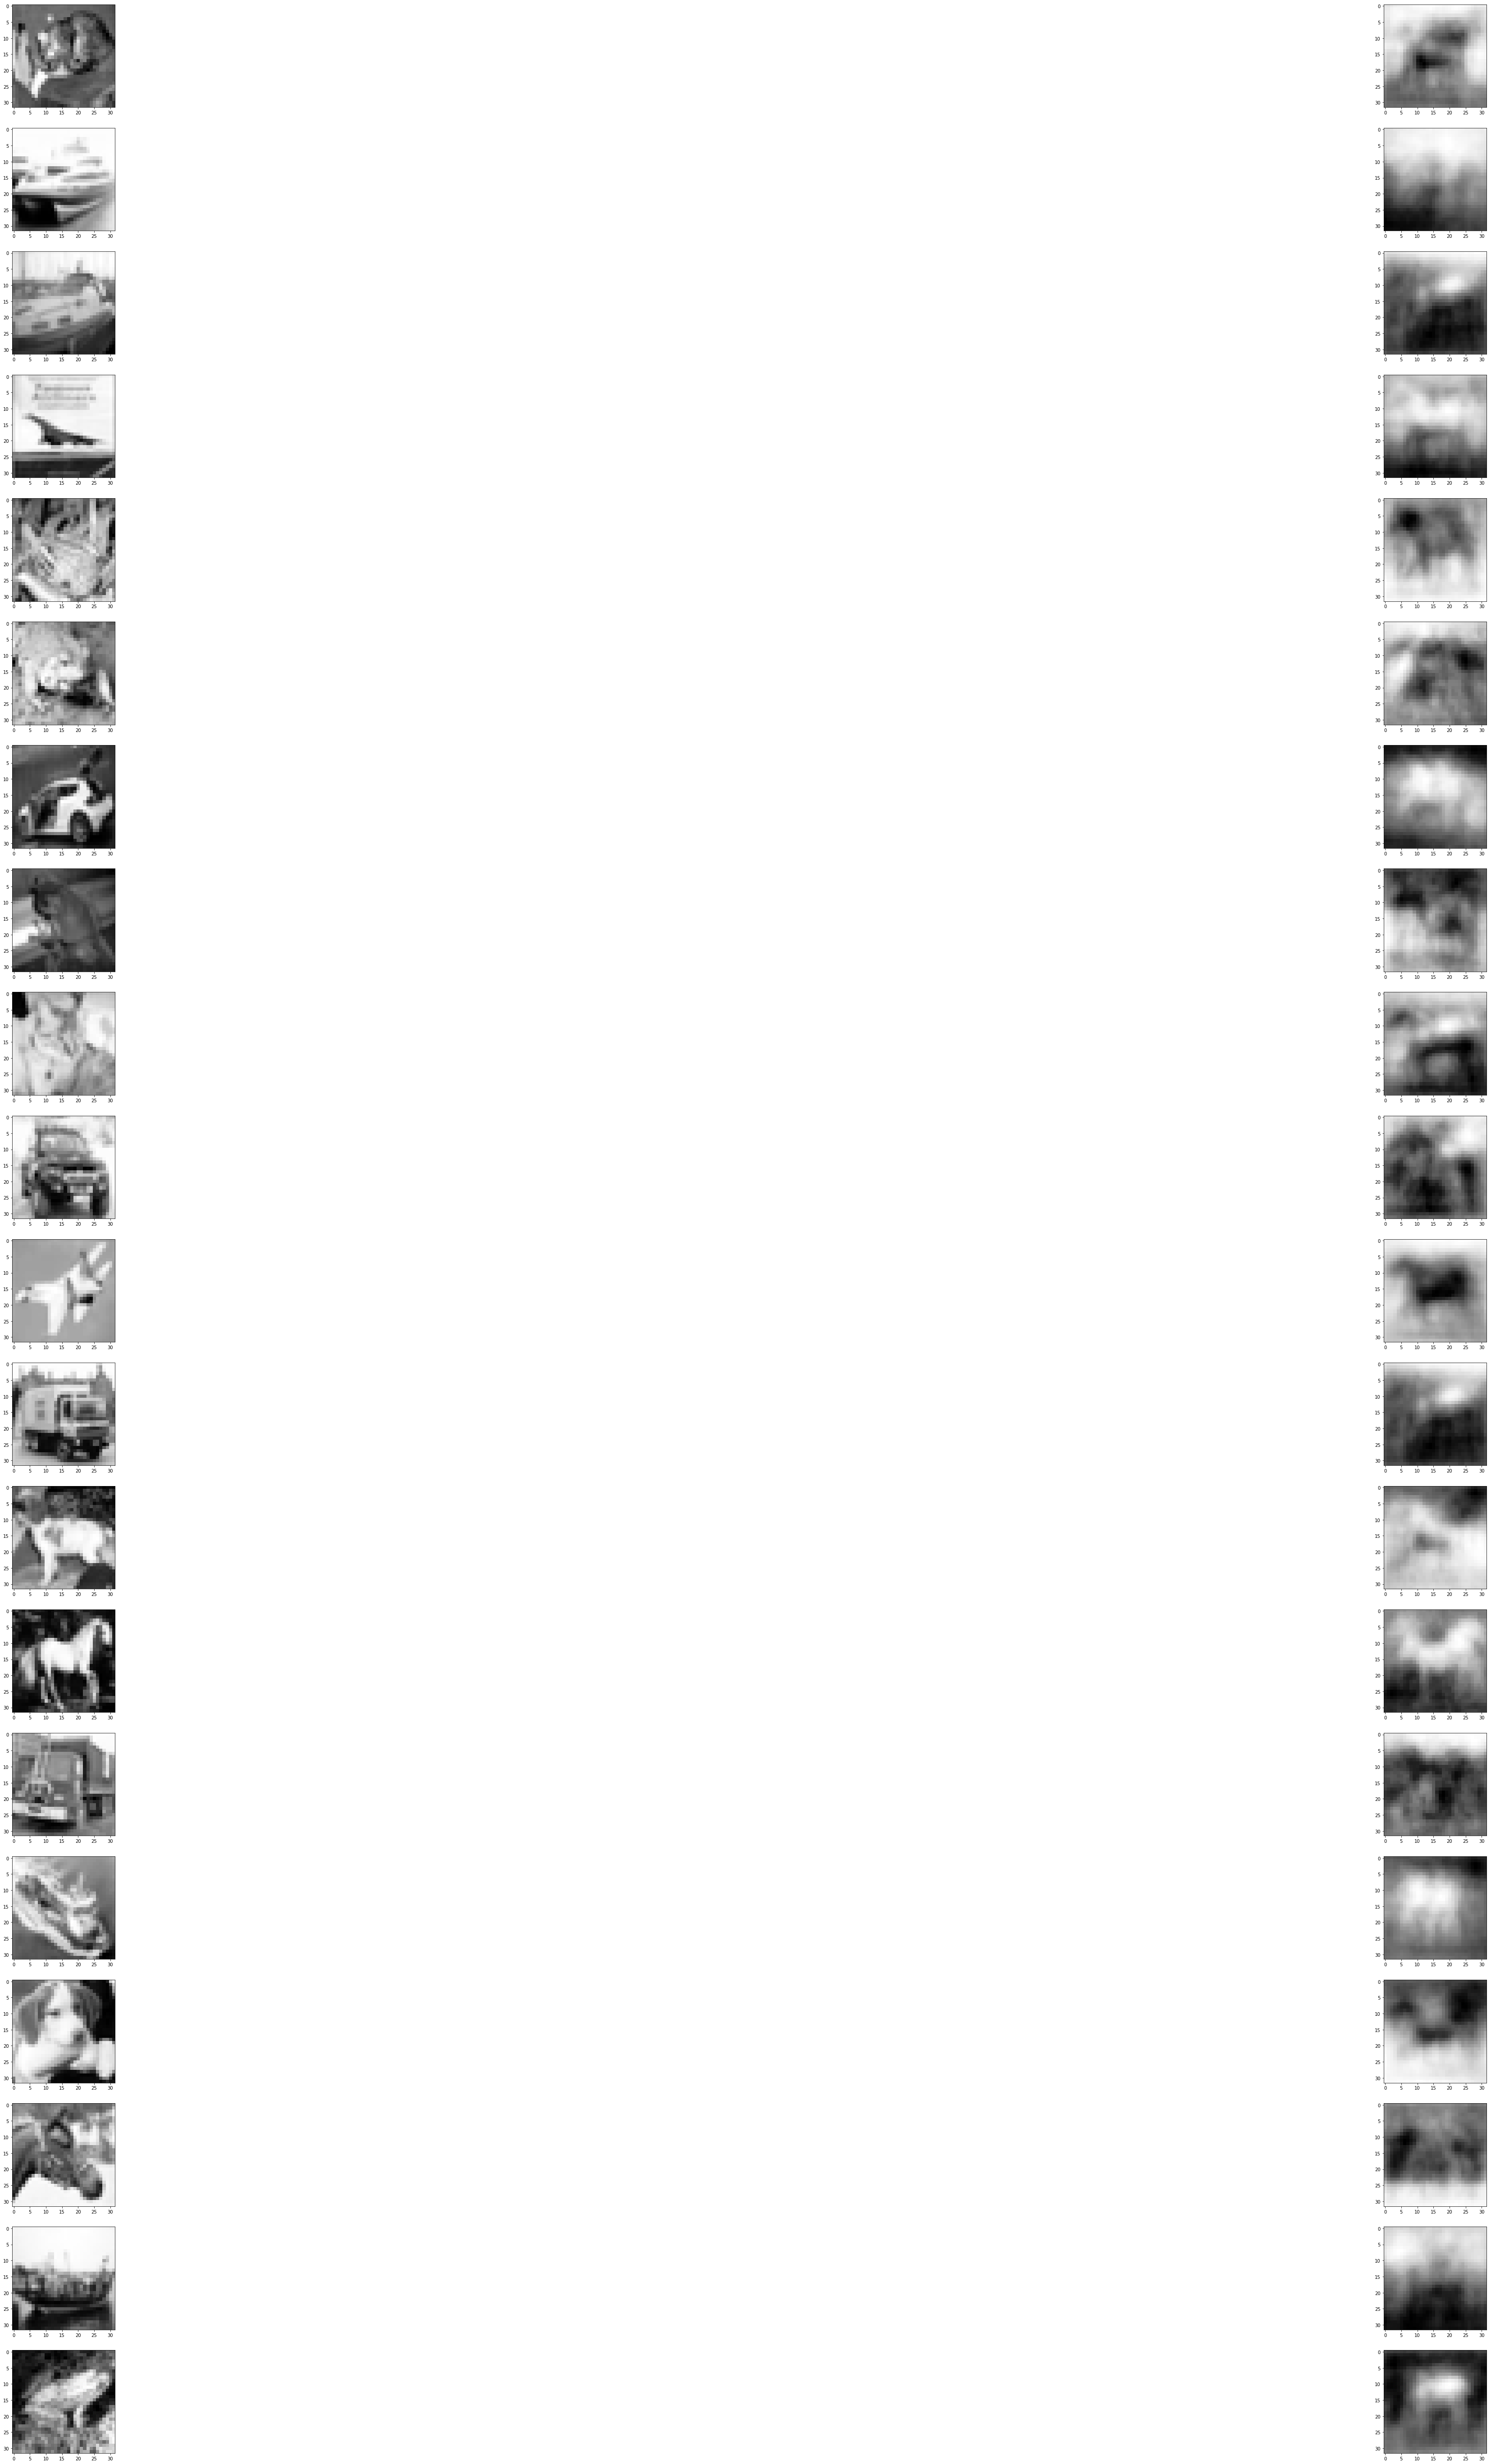

In [87]:
plt.rcParams['figure.figsize'] = (100, 100)
plt.figure()
for i in range(20):
    plt.subplot(20, 2, i*2 + 1)
    original_img = np.reshape(test_x[i, :], (32, 32))
    plt.imshow(original_img, cmap='Greys_r')
    
    plt.subplot(20, 2, i*2 + 2)
    reconstructed_img = decode(ae, [encodings[i]])
    plt.imshow(reconstructed_img, cmap='Greys_r')

plt.show();